In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from missingpy import KNNImputer
import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split as tts,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix,roc_auc_score,precision_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

In [3]:

#import os
#cwd = os.getcwd()
#importing the train dataset
train=pd.read_csv("/Users/vandana/Downloads/Data-Science-Hackathon-master/Hackathon - Are you sure to Insure/file/train.csv")
train.head()
copy_train=train.copy()
#cwd

In [4]:
#Shape of the complete dataset
train.shape

(50553, 12)

In [5]:
#Datatypes of all columns in the dataset
train.dtypes

ID                        int64
Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Claim                     int64
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Gender                   object
Age                       int64
dtype: object

In [6]:
#Checking for number of missing values in the dataset
train.isnull().sum()

ID                          0
Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  35953
Age                         0
dtype: int64

In [7]:
#Percentage of missing values in dataset
train.isnull().sum()/train.shape[0]*100

ID                       0.000000
Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Claim                    0.000000
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision (in value)     0.000000
Gender                  71.119419
Age                      0.000000
dtype: float64

#### Gender column has about 71% of missing values. We have option to drop the column or else replace it with "Not Present"

In [8]:
#Replace missing Gender values with "Not Present"
train['Gender']=train["Gender"].fillna("Not Present")

In [9]:
#Seperate numerical and categorical columns
numerical=train.select_dtypes(include=np.number)
categorical=train.select_dtypes(exclude=np.number)

In [10]:
#numerical part of dataset
numerical.head()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
0,3433,0,7,0.0,17.82,31
1,4339,0,85,69.0,0.00,36
2,34590,0,11,19.8,11.88,75
3,55816,0,16,20.0,0.00,32
4,13816,0,10,15.0,0.00,29


In [11]:
#categorical part of Dataset
categorical.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Gender
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,MALAYSIA,Not Present
1,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,Not Present
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,MALAYSIA,Not Present
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,INDONESIA,Not Present
4,EPX,Travel Agency,Online,Cancellation Plan,"KOREA, REPUBLIC OF",Not Present


#### "Claim" as such is a categorical column, so just add "Claim" column into categorical part of the dataset

In [12]:
#concatenating "Claim" into categorical column of the dataset
categorical=pd.concat([categorical,numerical["Claim"]],1)

In [13]:
#new categorcical part of dataset after adding Claim column to it 
categorical.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Gender,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,MALAYSIA,Not Present,0
1,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,Not Present,0
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,MALAYSIA,Not Present,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,INDONESIA,Not Present,0
4,EPX,Travel Agency,Online,Cancellation Plan,"KOREA, REPUBLIC OF",Not Present,0


#### Logically we can remove "ID" column from the dataset as "ID" of an indivisual should not decide whether he/she should be getting the Insurance Claim or not

In [14]:
#Dropping "ID" column from the dataset and also from numerical part of Dataset
train=train.drop(["ID"],1)
numerical=numerical.drop(["ID"],1)

In [15]:
#Checking for unique values in each numercial column
for num_col in list(numerical):
    print(num_col,train[num_col].unique())

Claim [0 1]
Duration [   7   85   11   16   10   64   23   31    5  100   71   18   15   20
   27  162  240  140    8   36    3   14   50   41   72   26   19    6
    1   81  133    2   21   12   30   56  132   55   28   61   69    4
   35  386   47   32  102   37   34   40   57   46   58  147   17   70
  375  186   13   76   62  431  138  127   74   52   45  192   22  109
   29  129  219   80  137   24  198  126  264    9   91    0  307  135
   38  166  403   66  365   63  180   87  174   68  125   94   92   43
  115  391   77   84   33   65   79   48   73   42   25  101  104  123
  373  366   95  106   78  151   75   83  112  364   39  208   97  371
   67   59  261  148  367   44   88  167   89  121  182   53  243  110
  369   54  202  122  142  163  124  268  150  170  117   49  372   86
  390  224  381   99   93  141  374  204  155   60  508   90  387  168
  217  252  159  160  116  236  205  247  114  183  370   51  176  190
   96   82  119  228  392  156  143  144  378  145  545 

#### "Duration" column has some negative vaues which can't be possible, so Let's replace nagtive values with the mean value of "Duration" column, we can also replace them with values nearest to it.

In [16]:
#Replacing negative values of "Duration" with mean value of "Duration" column
train.loc[train["Duration"]<0,"Duration"]=train["Duration"].mean()

#### As we have already seen during EDA there are few instances where "Commision" is high when "Net Sales" is zero or low which can't be possible logically. As we can't gain high commison unless we sale something. Replacing Commision value with "0 (zero)" where Net sales are "0 (zero)"

In [17]:
#Replacing Commision value with zero where Net sales are zero
train.loc[train["Net Sales"]==0,'Commision (in value)']=0.0

#### Different methods for calculating correlation between categorical variables
#### Carmer's V Method 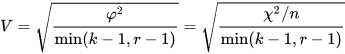

#### Phi-Coefficient 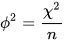

#### Contingency Co-efficient 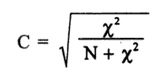

#### Reference: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

In [18]:
#Function to calculate Correlation of categorcial variables using Cramer's V method
def cramers_v_correlation(col1, col2):
    matrix = pd.crosstab(train[col1],train[col2])
    chi2 = ss.chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    phi2 = chi2/n
    r,k = matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [19]:
for col_1 in list(categorical):
    for col_2 in list(categorical):
        if((cramers_v_correlation(col_1,col_2)>0.8) and (col_1!=col_2)):
            print(col_1,"to",col_2,"correlation is",cramers_v_correlation(col_1,col_2))

Agency to Agency Type correlation is 0.9998615163948056
Agency to Distribution Channel correlation is 0.9512410165152818
Agency Type to Agency correlation is 0.9998615163948056
Agency Type to Product Name correlation is 0.9889657680364865
Agency Type to Gender correlation is 0.8654383804749617
Distribution Channel to Agency correlation is 0.9512410165152818
Distribution Channel to Product Name correlation is 0.943863560944548
Product Name to Agency Type correlation is 0.9889657680364865
Product Name to Distribution Channel correlation is 0.943863560944548
Gender to Agency Type correlation is 0.8654383804749617


#### As we can see through correlation value as "Agency Type" has very high correlation value with "Agency", "Product Name" and "Distribution Channel"

### Chi-square test for feature importance

In [20]:
#Function to calculate importance of features using Chi-Square test
def Chi_square(col_1,col_2):
    X=train[col_1].astype('str')
    Y=train[col_2].astype('str')
    observed_values=pd.crosstab(Y,X)
    chi2, p, dof, expected = ss.chi2_contingency(observed_values)
    if(p>0.05):
        print(col_1," is not required")
    else:
        print(col_1," is required")

In [21]:
for col in list(train):
    Chi_square(col,"Claim")

Agency  is required
Agency Type  is required
Distribution Channel  is not required
Product Name  is required
Claim  is required
Duration  is required
Destination  is required
Net Sales  is required
Commision (in value)  is required
Gender  is required
Age  is required


#### We can remove "Agency Type" to avoid Multicollinearity and "Distribution Channel" as its is not importnat as per Chi-Square test

In [22]:
#dropping columns which are not required
train=train.drop(["Distribution Channel",'Agency Type'],1)

In [23]:
train.head()

,Agency,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CWT,Rental Vehicle Excess Insurance,0,7.0,MALAYSIA,0.0,0.00,Not Present,31
1,EPX,Cancellation Plan,0,85.0,SINGAPORE,69.0,0.00,Not Present,36
2,CWT,Rental Vehicle Excess Insurance,0,11.0,MALAYSIA,19.8,11.88,Not Present,75
3,EPX,2 way Comprehensive Plan,0,16.0,INDONESIA,20.0,0.00,Not Present,32
4,EPX,Cancellation Plan,0,10.0,"KOREA, REPUBLIC OF",15.0,0.00,Not Present,29


In [24]:
train.shape

(50553, 9)

In [25]:
#Performing One-Hot encoding on dataset
dummy_train=pd.get_dummies(train)

In [26]:
#Shape of One-Hot encoded dataset
dummy_train.shape

(50553, 151)

In [27]:
#Dropping unnecessary columns for One-Hot encoded dataset
dummy_train=dummy_train.drop(["Agency_ADM","Product Name_1 way Comprehensive Plan","Destination_ARGENTINA","Gender_F"],1)

In [28]:
#New shape of One-Hot Encoded dataset
dummy_train.shape

(50553, 147)

In [29]:
#Performing scaling o Dataset
scaler=StandardScaler()
dummy_train_scaled=pd.DataFrame(scaler.fit_transform(dummy_train),columns=list(dummy_train))

In [30]:
#scaled dataset
dummy_train_scaled.head()

,Claim,Duration,Net Sales,Commision (in value),Age,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA,Gender_M,Gender_Not Present
0,-0.121967,-0.418296,-0.834389,-0.474719,-0.640165,-0.07355,-0.388551,-0.040061,-0.055993,-0.036701,...,-0.065506,-0.14493,-0.203907,-0.013344,-0.008896,-0.008896,-0.166083,-0.00629,-0.418259,0.637249
1,-0.121967,0.350685,0.576677,-0.474719,-0.284961,-0.07355,-0.388551,-0.040061,-0.055993,-0.036701,...,-0.065506,-0.14493,-0.203907,-0.013344,-0.008896,-0.008896,-0.166083,-0.00629,-0.418259,0.637249
2,-0.121967,-0.378861,-0.429475,0.135019,2.485628,-0.07355,-0.388551,-0.040061,-0.055993,-0.036701,...,-0.065506,-0.14493,-0.203907,-0.013344,-0.008896,-0.008896,-0.166083,-0.00629,-0.418259,0.637249
3,-0.121967,-0.329567,-0.425385,-0.474719,-0.569124,-0.07355,-0.388551,-0.040061,-0.055993,-0.036701,...,-0.065506,-0.14493,-0.203907,-0.013344,-0.008896,-0.008896,-0.166083,-0.00629,-0.418259,0.637249
4,-0.121967,-0.388720,-0.527636,-0.474719,-0.782247,-0.07355,-0.388551,-0.040061,-0.055993,-0.036701,...,-0.065506,-0.14493,-0.203907,-0.013344,-0.008896,-0.008896,-0.166083,-0.00629,-0.418259,0.637249


In [31]:
#Sorting target column and features
X=dummy_train_scaled.drop(["Claim"],1)
y=train["Claim"]

#### Feature Selection using Backward Elimination

In [32]:
#Function to perform Backward Elimination
import statsmodels.api as sm
cols = list(X.columns)
pmax = 1
while (pmax>0.05):
    p=[]
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        breakselected_features_BE = cols
print("Best features using Backward Elimination: ",cols)

Best features using Backward Elimination:  ['Net Sales', 'Commision (in value)', 'Age', 'Agency_C2B', 'Product Name_2 way Comprehensive Plan', 'Product Name_Annual Silver Plan', 'Product Name_Annual Travel Protect Gold', 'Product Name_Annual Travel Protect Platinum', 'Product Name_Comprehensive Plan', 'Product Name_Individual Comprehensive Plan', 'Product Name_Silver Plan', 'Product Name_Single Trip Travel Protect Gold', 'Product Name_Single Trip Travel Protect Platinum', 'Product Name_Spouse or Parents Comprehensive Plan']


In [33]:
#Sorting out target column and important features selected using feature selection method
new_X=dummy_train_scaled[cols]
new_y=train["Claim"]

In [34]:
#Checking data imbalance 
new_y.value_counts()/train.shape[0]*100

0    98.534212
1     1.465788
Name: Claim, dtype: float64

#### Dataset contains huge Data imbalance, applying SMOTE to remove Data imbalance

In [35]:
#Intializing SMOTE 
sm=SMOTE(random_state=0)

In [36]:
#Removing Data imbalance using SMOTE 
sm_X,sm_y=sm.fit_sample(new_X,new_y)

In [37]:
#Checking for Data imbalance again
pd.Series(sm_y).value_counts()

1    49812
0    49812
dtype: int64

In [38]:
#Performing Train-Test split
X_train,X_test,y_train,y_test=tts(sm_X,sm_y,test_size=0.3,random_state=0)

In [39]:
pd.Series(y_test).value_counts()

1    15065
0    14823
dtype: int64

In [40]:
#Intializing Simple Logistic Regression Model
logreg=LogisticRegression()

In [41]:
#Fitting Logistic Regression Model on Train set
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
#Performing prediction on test set
y_pred=logreg.predict(X_test)

In [43]:
#Calculating Accuracy score
accuracy_score(y_test,y_pred)

0.7522751605995718

In [44]:
#Printing Classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77     14823
           1       0.81      0.66      0.73     15065

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



In [45]:
roc_auc_score(y_test,y_pred)

0.7530370172437909

In [46]:
def curve_roc(model,X_test,y_test):
    probs=model.predict_proba(X_test)
    probs = probs[:, 1]
    probs.shape
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.show()

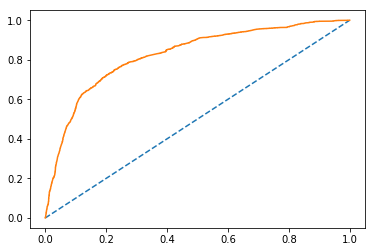

In [47]:
curve_roc(logreg,X_test,y_test)

#### Precision and Recall looks descent 

#### Performing Hyper Parameter tunning and Cross-validation using GridSearchCV

In [48]:
#Defining parameters for GridSearchCV
logreg_param={"C":np.arange(0.01,1,0.01),
             "penalty":['l1','l2']}

In [49]:
#Initializing GridSearchCV with 5 Fold Cross validation 
logreg_cv=GridSearchCV(estimator=logreg,param_grid=logreg_param,cv=5)

In [50]:
#Fitting GridSearchCV model on Train Set
logreg_cv.fit(sm_X,sm_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.01, 0.02...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,


In [51]:
#Best Estimator after GridSearchCV
logreg_cv.best_estimator_

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
#Performing prediction on Test set using best estimator
y_pred_cv=logreg_cv.best_estimator_.predict(X_test)

In [53]:
#Accuracy Score for best estimator
accuracy_score(y_test,y_pred_cv)

0.753546573875803

In [54]:
#Classification Report for Best Estimator
print(classification_report(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77     14823
           1       0.82      0.66      0.73     15065

    accuracy                           0.75     29888
   macro avg       0.76      0.75      0.75     29888
weighted avg       0.76      0.75      0.75     29888



In [55]:
roc_auc_score(y_test,y_pred_cv)

0.7543204346077386

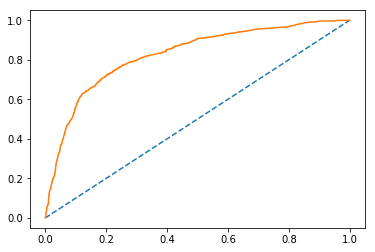

In [56]:
curve_roc(logreg_cv,X_test,y_test)

In [57]:
feature_importance=list(logreg_cv.best_estimator_.coef_.T)
features=list(cols)
f_imp= pd.DataFrame(list(zip(features,feature_importance)), columns =['Features', 'Importance']) 
f_imp.sort_values(by="Importance",ascending=False)

,Features,Importance
3,Agency_C2B,[0.814614394133095]
1,Commision (in value),[0.42836002867220824]
4,Product Name_2 way Comprehensive Plan,[0.41181063659811384]
0,Net Sales,[0.2261352832938993]
11,Product Name_Single Trip Travel Protect Gold,[0.10560188198997303]
8,Product Name_Comprehensive Plan,[0.09991085302140265]
12,Product Name_Single Trip Travel Protect Platinum,[0.08471234495644618]
9,Product Name_Individual Comprehensive Plan,[0.08428159675138912]
13,Product Name_Spouse or Parents Comprehensive Plan,[0.051020591113952025]
10,Product Name_Silver Plan,[0.031122596484341798]


In [58]:
feature_importance=list(logreg.coef_.T)
features=list(cols)
f_imp= pd.DataFrame(list(zip(features,feature_importance)), columns =['Features', 'Importance']) 
f_imp.sort_values(by="Importance",ascending=False)

,Features,Importance
3,Agency_C2B,[0.8102818022639836]
1,Commision (in value),[0.44676746487399693]
4,Product Name_2 way Comprehensive Plan,[0.42209730936361645]
0,Net Sales,[0.22182305788248122]
8,Product Name_Comprehensive Plan,[0.10650261302549413]
11,Product Name_Single Trip Travel Protect Gold,[0.103966077949586]
12,Product Name_Single Trip Travel Protect Platinum,[0.08521697385134512]
9,Product Name_Individual Comprehensive Plan,[0.08344649222248685]
13,Product Name_Spouse or Parents Comprehensive Plan,[0.05606770387343292]
10,Product Name_Silver Plan,[0.036948763524773616]


In [59]:
#Importing Test Dataset
test=pd.read_csv("/Users/vandana/Downloads/Data-Science-Hackathon-master/Hackathon - Are you sure to Insure/file/test.csv")
test.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,25902,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,58,ICELAND,49.5,29.7,NaN,47
1,19535,EPX,Travel Agency,Online,2 way Comprehensive Plan,4,SINGAPORE,20.0,0.0,NaN,24
2,43717,EPX,Travel Agency,Online,2 way Comprehensive Plan,68,VIET NAM,20.0,0.0,NaN,36
3,48271,EPX,Travel Agency,Online,2 way Comprehensive Plan,41,CHINA,28.0,0.0,NaN,36
4,52318,EPX,Travel Agency,Online,Cancellation Plan,16,SINGAPORE,11.0,0.0,NaN,36


In [60]:
#Seprating ID's required for Final Submission
test_id=test["ID"]

In [61]:
#Dropping unwanted columns
test=test.drop(["Distribution Channel","Agency Type","ID"],1)

In [62]:
#One-Hot encoding Test set
new_test=pd.get_dummies(test)

In [63]:
#Intializing test set with same column
new_test=new_test[cols]

In [64]:
new_test.shape

(12661, 14)

In [65]:
#Final prediction for submission
final_predict=logreg_cv.best_estimator_.predict(new_test)

In [66]:
#Saving the submission file
submit_id=list(test_id)
submit_pred=list(final_predict)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['ID', 'Claim'])
final_submission.to_csv("/Users/vandana/Downloads/Data-Science-Hackathon-master/Hackathon - Are you sure to Insure/file/submission_12.csv",index=False)

In [67]:
le=LabelEncoder()

In [68]:
copy_train['Gender']=copy_train['Gender'].fillna("Not Present")

In [69]:
def encode(col):
    copy_train[col]=le.fit_transform(copy_train[col])

In [70]:
encode("Agency")
encode("Agency Type")
encode("Distribution Channel")
encode("Product Name")
encode("Destination")
encode("Gender")

In [71]:
rfc=RandomForestClassifier(random_state=0,oob_score=True)

In [72]:
sm=SMOTE(random_state=0)

In [73]:
X=copy_train.drop(["Claim"],1)
y=copy_train["Claim"]

In [74]:
X_new,y_new=sm.fit_sample(X,y.ravel())

In [75]:
X_train,X_test,y_train,y_test=tts(X_new,y_new,test_size=0.3,random_state=0)

In [76]:
rfc.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [77]:
y_pred_rfc=rfc.predict(X_test)

In [78]:
accuracy_score(y_test,y_pred_rfc)

0.9867170770877944

In [79]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14823
           1       0.99      0.98      0.99     15065

    accuracy                           0.99     29888
   macro avg       0.99      0.99      0.99     29888
weighted avg       0.99      0.99      0.99     29888



In [ ]:
result_cv=cross_val_score(estimator=rfc,X=X_new,y=y_new,cv=5)

In [ ]:
result_cv.mean()

In [ ]:
result_cv.std()

In [ ]:
roc_auc_score(y_test,y_pred_rfc)

In [ ]:
rfc.oob_score_

In [ ]:
dt=DecisionTreeClassifier(criterion='entropy')

In [ ]:
dt.fit(X_train,y_train)

In [ ]:
y_pred_dt=dt.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred_dt)

In [ ]:
print(classification_report(y_test,y_pred_dt))

In [ ]:
roc_auc_score(y_test,y_pred_dt)